In [1]:
using Clustering
using LinearAlgebra
using Plots
using Random
using Statistics

┌ Info: Precompiling Plots [91a5bcdd-55d7-5caf-9e0b-520d859cae80]
└ @ Base loading.jl:1342


In [2]:
using Pkg
Pkg.activate(@__DIR__)

  Activating environment at `~/JuliaProjects/KPLMCenters.jl/Project.toml`


In [3]:
using Revise

In [4]:
using KPLMCenters

In [5]:
rng = MersenneTwister(1234)

MersenneTwister(1234)

In [7]:
points = infinity_symbol(rng, 500, 50, 0.05, 3, -7, 7)

3×550 Matrix{Float64}:
 0.697957   -0.118054    2.28763    …   5.62311   -3.93284    6.47029
 0.728455    0.194283    0.76498       -0.450014   2.12498   -3.58049
 0.0217516   0.0196361  -0.0768125      0.128043   0.288267   6.4839

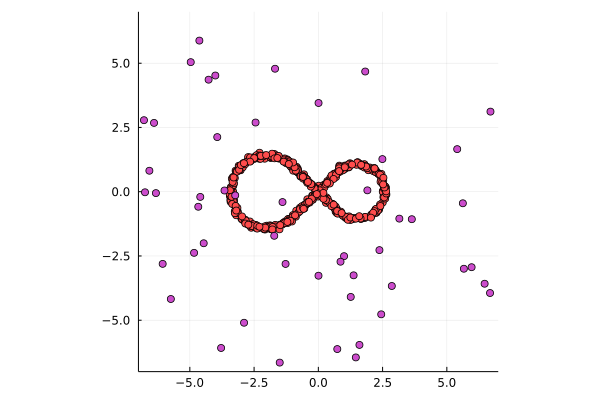

In [8]:
colors = vcat(ones(Int, 500), zeros(Int, 50))
scatter(points[1,:], points[2,:], marker_z=colors,
        color=:lightrainbow, legend=false, aspect_ratio=:equal)
xlims!(-7,7)
ylims!(-7,7)

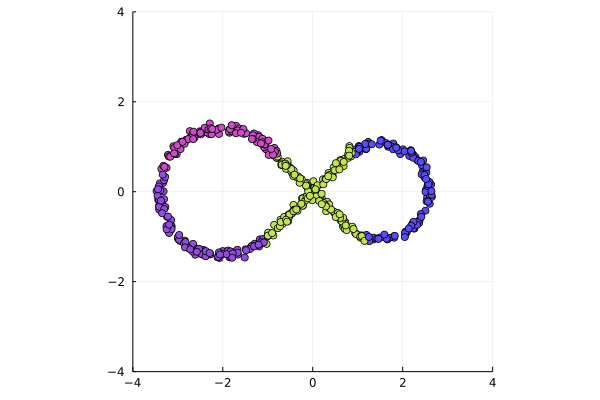

In [25]:
using Clustering

result = kmeans(points, 10); # run K-means for the 10 clusters

s = colors .> 0

scatter(points[1,s], points[2,s], marker_z=result.assignments,
        color=:lightrainbow, legend=false, aspect_ratio=:equal)
xlims!(-4,4)
ylims!(-4,4)


# Simple version 

Aucune contrainte sur les matrices de covariance.

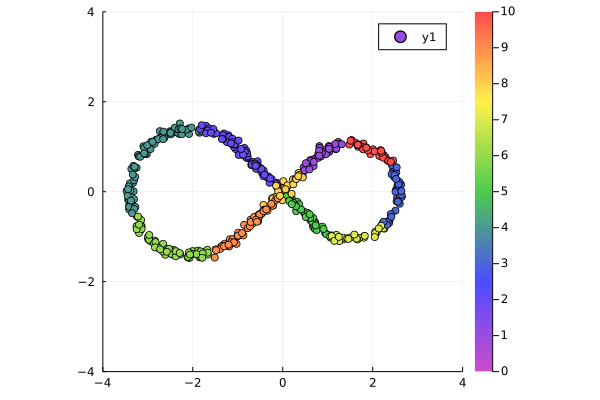

In [21]:
k = 20 
c = 10 
signal = 500
iter_max = 10
nstart = 1
function f_Σ(Σ) end
centers, μ, weights, colors, Σ, cost = kplm( rng, points, k, c, 
    signal, iter_max, nstart, f_Σ)

s = colors .> 0
scatter(points[1,s], points[2,s], 
    marker_z=colors, color=:lightrainbow, aspect_ratio=:equal )
xlims!(-4,4)
ylims!(-4,4)

# Constraint det = 1

Les matrices sont contraintes à avoir leur déterminant égal à 1.

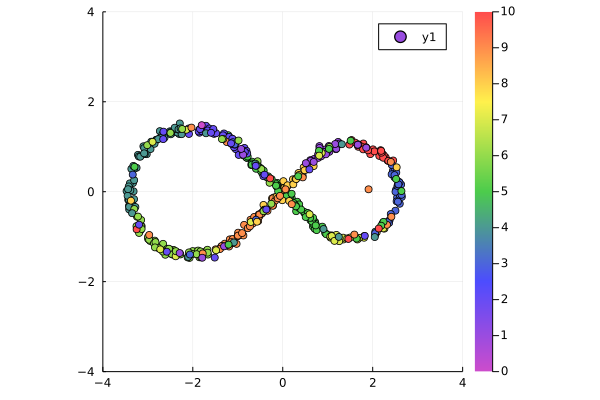

In [22]:
dimension = 3
function f_Σ_det1(Σ) 
    Σ .= Σ / (det(Σ))^(1/dimension)
end

centers, μ, weights, colors, Σ, cost = kplm( rng, points, k, c, signal, iter_max, 
    nstart, f_Σ_det1)

s = colors .> 0
scatter(points[1,s], points[2,s], 
    marker_z=colors, color=:lightrainbow, aspect_ratio=:equal )
xlims!(-4,4)
ylims!(-4,4)

# Constraint dim d 

Les matrices sont contraintes à avoir d-d_prim 
valeurs propres égales (les plus petites)
Ces d-dprim sont contraintes à être entre s2min et s2max, alors que les 
d_prim plus grandes valeurs propres sont contraintes à être supérieures à lambdamin.

In [23]:
function aux_dim_d(Σ, s2min, s2max, λmin, d_prim)

    eig = eigen(Σ)
    v = eig.vectors
    λ = eig.values

    new_λ = copy(λ)

    d = length(λ)
    for i = 1:d_prim
        new_λ[i] = (λ[i] - λmin) * (λ[i] >= λmin) + λmin
    end
    if d_prim < d
        S = mean(λ[1:(end-d_prim)])
        s2 =
            (S - s2min - s2max) * (s2min < S) * (S < s2max) +
            (-s2max) * (S <= s2min) + (-s2min) * (S >= s2max) + s2min + s2max
        new_λ[1:(end-d_prim)] .= s2
    end

    return v * Diagonal(new_λ) * transpose(v)

end

aux_dim_d (generic function with 1 method)

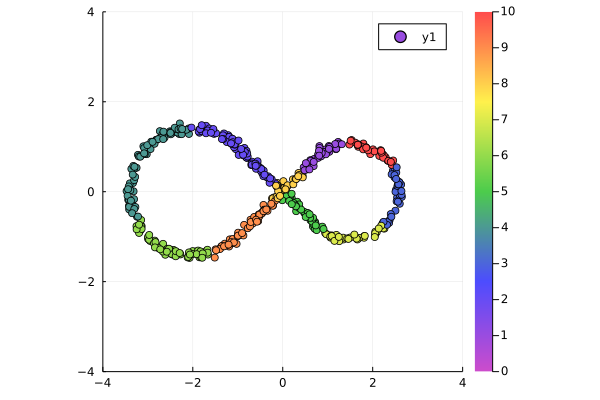

In [28]:
d_prim = 1
lambdamin = 0.1
s2min = 0.01
s2max = 0.02

function f_Σ_dim_d(Σ) 
    Σ .= aux_dim_d(Σ, s2min, s2max, lambdamin, d_prim)
end

centers, μ, weights, colors, Σ, cost = kplm( rng, points, k, c, 
    signal, iter_max, nstart, f_Σ_dim_d)

s = colors .> 0
scatter(points[1,s], points[2,s], 
    marker_z=colors, color=:lightrainbow, aspect_ratio=:equal )
xlims!(-4,4)
ylims!(-4,4)